In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
pip install pmdarima

     |████████████████████████████████| 460kB 14kB/s eta 0:00:018
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pmdarima as pm

In [19]:
df1 = pd.read_csv('us_soybean_futures_2009_to_2019.csv')
df2 = pd.read_csv('us_soybean_futures_1990_to_2009.csv')
df = pd.concat([df1, df2])
df.to_csv('us_soybean_futures_1990_to_2019.csv')

In [4]:
df = pd.read_csv('us_soybean_futures_1990_to_2019.csv', 
                 parse_dates=['Date'], index_col='Date')
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df = df['Price'].to_frame()
df = df.iloc[::-1]
df.head()

,Price
Date,
1990-01-02,561.25
1990-01-03,567.25
1990-01-04,563.25
1990-01-05,564.50
1990-01-08,570.75


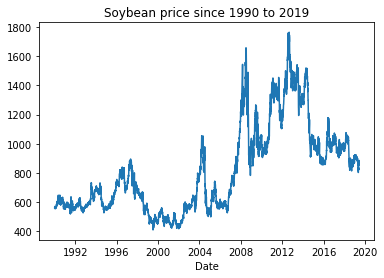

In [5]:
plt.xlabel('Date')
plt.title('Soybean price since 1990 to 2019')
plt.plot(df)

In [16]:
def get_stationarity(timeseries):
    
    #rolling statistics
    rolling_mean = timeseries.rolling(window=365).mean()
    rolling_std = timeseries.rolling(window=365).std()
    
    #rolling plot
    plt.plot(timeseries, color='skyblue', label='original')
    plt.plot(rolling_mean, color='lightcoral', label='rolling mean')
    plt.plot(rolling_std, color='grey', label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Dickey-Fuller test
    result = adfuller(timeseries['Price'])

    print('ADF statistics: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

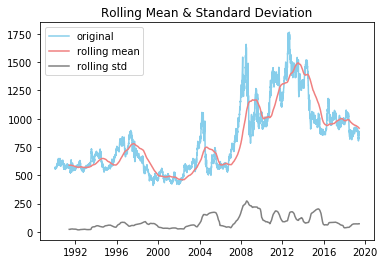

ADF statistics: -1.972178229394908
p-value: 0.2989036002457443
Critical Values:
	1%: -3.431214365672586
	5%: -2.861921984693443
	10%: -2.56697332600001


In [17]:
get_stationarity(df)

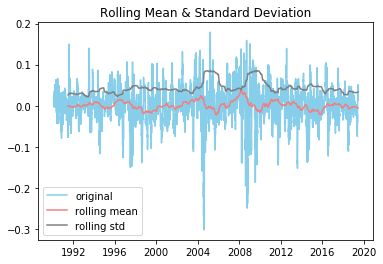

ADF statistics: -10.145366735525384
p-value: 8.212944857566387e-18
Critical Values:
	1%: -3.431217576612353
	5%: -2.8619234034804713
	10%: -2.5669740812395783


In [18]:
df_log = np.log(df)
rolling_mean = df_log.rolling(window=30).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean)

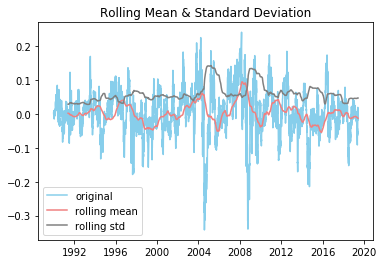

ADF statistics: -7.270102680489338
p-value: 1.5966901446033655e-10
Critical Values:
	1%: -3.4312142514356885
	5%: -2.861921934216657
	10%: -2.5669732991305376


In [19]:
rolling_mean_exp_decay = df_log.ewm(halflife=30, min_periods=0, adjust=True).mean()
df_log_minus_exp_decay = df_log - rolling_mean_exp_decay
df_log_minus_exp_decay.dropna(inplace=True)

get_stationarity(df_log_minus_exp_decay)

In [59]:
def dif(dataset):
    diff = []
    for i in range(0, len(dataset)-1):
        value = dataset[i+1] - dataset[i]
        diff.append(value)
    return pd.Series(diff)

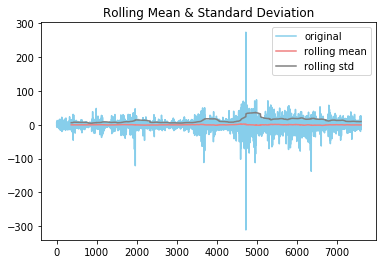

KeyError: 'Price'

In [60]:
df_dif1 = dif(df.Price)
get_stationarity(df_dif1)

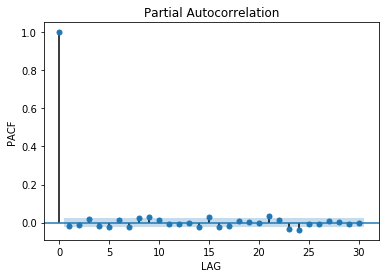

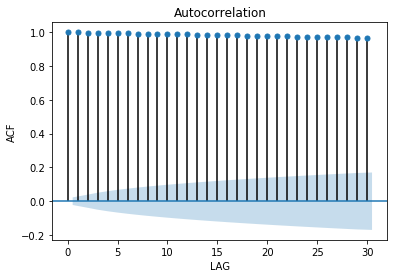

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(df_dif1, lags=30)
plt.xlabel('LAG')
plt.ylabel('PACF')
plt.show()

plot_acf(df, lags=30)
plt.xlabel('LAG')
plt.ylabel('ACF')
plt.show()

/Users/spkaikai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/spkaikai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


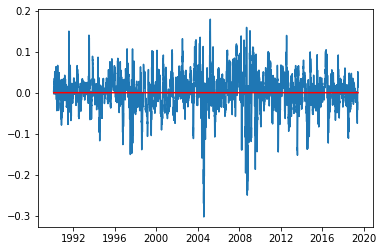

In [14]:
model = ARIMA(df_log_minus_mean, order=(0,1,0))
results = model.fit()
plt.plot(df_log_minus_mean)
plt.plot(results.fittedvalues, color='r')

In [9]:
stepwise_fit = pm.auto_arima(df_log_minus_mean, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-41592.304, BIC=-41557.651, Fit time=38.512 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-36726.040, BIC=-36712.179, Fit time=2.463 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-38702.724, BIC=-38675.002, Fit time=11.390 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-41855.104, BIC=-41827.382, Fit time=23.239 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-41814.171, BIC=-41779.518, Fit time=52.896 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-36726.327, BIC=-36705.535, Fit time=1.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-41662.267, BIC=-41627.613, Fit time=83.616 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-41761.791, BIC=-41720.207, Fit time=145.266 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-42019.584, BIC=-41998.793, Fit time

In [10]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7573
Model:             SARIMAX(0, 1, 0)x(1, 1, 2, 12)   Log Likelihood               21017.461
Date:                            Wed, 25 Sep 2019   AIC                         -42024.923
Time:                                    19:01:03   BIC                         -41990.270
Sample:                                         0   HQIC                        -42013.028
                                           - 7573                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.501e-06   1.94e-06     -2.317      0.020   -8.31e-06   -6.94e-07
ar.S.L12      -0.9996      0.008   -123.409      0.000      -1.016      -0.984
ma.S.L12      -0.0009      3.620     -0.000      1.000      -7.096       7.094
ma.S.L24      -0.9991      3.610     -0.277      0.782      -8.074       6.076
sigma2         0.0002      0.001      0.277      0.782      -0.001       0.002
===================================================================================
Ljung-Box (Q):                      201.00   Jarque-Bera (JB):            102837.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.81
Prob(H) (two-sided):                  0.02   Kurtosis:                        21.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
stepwise_fit.order

(0, 1, 0)

In [62]:
stepwise_fit_df = pm.auto_arima(df, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=62002.615, BIC=62037.288, Fit time=25.013 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=67223.313, BIC=67237.182, Fit time=0.434 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=65196.576, BIC=65224.313, Fit time=6.870 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=61995.973, BIC=62023.711, Fit time=25.988 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=61997.752, BIC=62032.424, Fit time=30.858 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=67224.668, BIC=67245.472, Fit time=1.113 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=61997.730, BIC=62032.403, Fit time=83.531 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=61999.926, BIC=62041.533, Fit time=43.618 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=61995.625, BIC=62016.429, Fit time=21.654 seconds
Fit 

In [63]:
stepwise_fit_df.order

(0, 1, 0)

In [64]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [65]:
auto = pm.auto_arima(df, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=62014.386, BIC=62028.258, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=62014.564, BIC=62035.372, Fit time=0.047 seconds
Fit ARIMA: order=(0, 1, 1); AIC=62014.526, BIC=62035.334, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 1); AIC=62016.243, BIC=62043.987, Fit time=0.601 seconds
Total fit time: 1.188 seconds


In [66]:
auto.order

(0, 1, 0)